In [13]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
import seaborn as sns
from datetime import datetime
from utils.neural_network import train_nn, get_device

from utils.load_data import load_data, load_gt_data
from utils.preprocessing_v2 import Preprocessing, get_gt_diff_logs
from utils.results import bootstrap_ensemble, interactive_plot_predictions, summarize_results
import utils.results as results
import torch
import torch.nn as nn
import os 

TRENDS_FOLDER = 'data/google_trends/'
GDP_FOLDER = 'data/gdp/'
DATA_PREFIX = 'trends_data_by_topic_'

EPS = 1e-15
SEED = 42

os.environ['PATH'] += ':/Users/leonardamsler/bin'
plt.style.use('ieee.mplstyle')

## Loading and Preprocessing Data

### Loading Google Trends

In [14]:
TRAIN_PROPORTION = 0.9
MODE = "pct" # None | "pct" | "diff"
PERIOD = 4  # Year to year prediction

In [15]:
data, all_gdps, all_gts = load_data()
data['country'].unique()

array(['Switzerland', 'Germany', 'United Kingdom', 'Japan', 'Canada',
       'Korea', 'United States'], dtype=object)

In [16]:
preprocessor = Preprocessing(epsilon=EPS, gdp_diff_period=PERIOD, all_GDPs=all_gdps, all_GTs=all_gts)

X_train, y_train, X_valid, y_valid, x_high_freq = preprocessor.preprocess_data(train_pct=TRAIN_PROPORTION, 
                                                                  mode="diff", 
                                                                  take_log_diff_gdp=True,
                                                                  gt_trend_removal=False, 
                                                                  keep_pca_components=180, 
                                                                  noisy_data_stds=[0.001, 0.005, 0.01], 
                                                                  add_encoded_month=False, 
                                                                  gt_data_transformations=[get_gt_diff_logs], other_params={'plot_pca': False})

print(all_gts['country'].unique())

X_train shape : (1780, 180)
X_valid shape : (53, 180)
y_train shape : (1780,)
y_valid shape : (53,)
X_high_freq shape : (1547, 180)
['Switzerland' 'Germany' 'United Kingdom' 'Japan' 'Canada' 'Korea'
 'United States']


## Simple Prediction Model

Using mps device


100%|██████████| 100/100 [00:00<00:00, 110.37it/s]


Final training loss: 0.01411503367125988
Final validation loss: 0.49500030279159546
Final validation R^2: 0.341994984856945


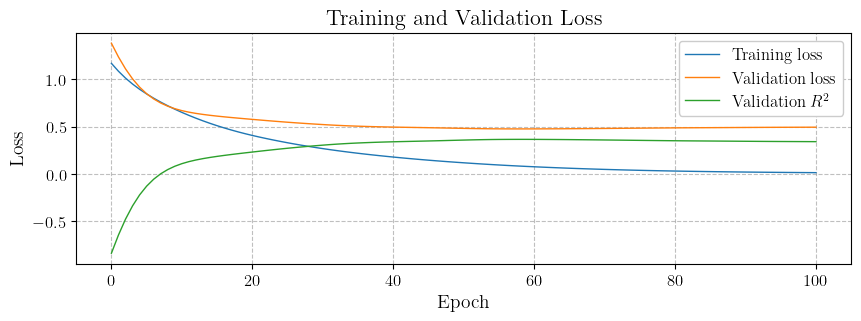

Best R^2: 0.36623771440346997 at epoch 58


In [17]:
model, training_loss, validation_loss, validation_r_squared, mse_losses = train_nn(X_train, 
                                                                       y_train, 
                                                                       X_valid, 
                                                                       y_valid, 
                                                                       num_epochs=100, 
                                                                       learning_rate=1e-4, 
                                                                       weight_decay=1e-2, 
                                                                       verbose=True,
                                                                       seed=SEED)

# Compute best r squared with epoch
best_r_squared = max(validation_r_squared)
best_epoch = validation_r_squared.index(best_r_squared)

print(f"Best R^2: {best_r_squared} at epoch {best_epoch}")

## Ensembling

In [18]:
train_fn = lambda seed: train_nn(X_train, y_train, X_valid, y_valid, num_epochs=100, learning_rate=1e-4, weight_decay=1e-2, verbose=False, seed=seed)
bootstrapped_results = bootstrap_ensemble(X_valid, y_valid, train_fn, n_ensembling=10, seed=SEED, device=get_device(False), other_pred_set=X_train)

best_model = bootstrapped_results['best_model']
y_pred_best = bootstrapped_results['y_pred_best']
y_pred_mean = bootstrapped_results['y_pred_mean']
y_pred_std = bootstrapped_results['y_pred_std']
y_pred_median = bootstrapped_results['y_pred_median']
best_rsquared = bootstrapped_results['best_rsquared']
mse_ensemble = bootstrapped_results['mse_ensemble']
rsquared_ensemble = bootstrapped_results['rsquared_ensemble']
mape_ensemble = bootstrapped_results['mape_ensemble']

Bootstrapping Ensembling: 100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


Ensemble R2: 0.42015252699305483
Ensemble MSE: 0.4362043789813033
Ensemble MAPE: 167.76600942315764
Ensemble R2: 0.42015252699305483
Ensemble MSE: 0.4362043789813033
Ensemble MAPE: 167.76600942315764


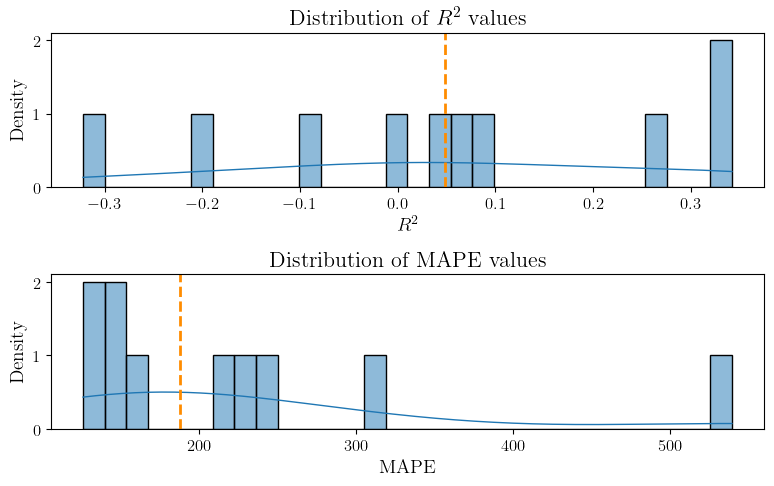

In [19]:
plt.figure(figsize=(8, 5))
plt.subplot(2,1,1)
summarize_results(y_valid, y_pred_mean, rsquared_ensemble, metric_name='$R^2$')
plt.axvline(x=np.median(rsquared_ensemble), color='darkorange', linestyle='--', label='Median $R^2$', linewidth=2)
plt.subplot(2,1,2)
summarize_results(y_valid, y_pred_mean, mape_ensemble, metric_name='MAPE')
plt.axvline(x=np.median(mape_ensemble), color='darkorange', linestyle='--', label='Median MAPE', linewidth=2)
plt.tight_layout()
plt.savefig(results.OUTPUT_DATA_PATH + 'simple_nn_r2_mape_scores.pdf')
plt.show()

In [20]:
print(f"Median R^2: {np.median(rsquared_ensemble)}")
print(f"Median MAPE: {np.median(mape_ensemble)}")

Median R^2: 0.04856084344468453
Median MAPE: 187.79618874302378


In [21]:
plt.rcdefaults()
interactive_plot_predictions(
    country_valid=preprocessor.country_valid,
    y_valid=y_valid,
    y_pred_mean=y_pred_mean,
    y_pred_median=y_pred_median,
    y_pred_best=y_pred_best,
    y_pred_std=y_pred_std,
    title_prefix="GDP Prediction: "
)

interactive(children=(Dropdown(description='selected_country', options=('Canada', 'Germany', 'Japan', 'Korea',…

Using mps device


100%|██████████| 100/100 [00:01<00:00, 95.40it/s]


Final training loss: 0.01411503367125988
Final validation loss: 0.49500030279159546
Final validation R^2: 0.341994984856945


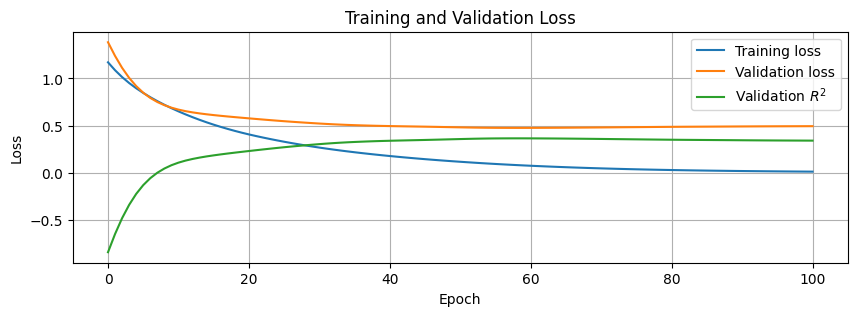

In [22]:
device = get_device(False)

model, training_loss, validation_loss, validation_r_squared, mse_losses = train_nn(X_train, 
                                                                       y_train, 
                                                                       X_valid, 
                                                                       y_valid, 
                                                                       num_epochs=100, 
                                                                       learning_rate=1e-4, 
                                                                       weight_decay=1e-2, 
                                                                       verbose=True,
                                                                       seed=SEED)

# Get the predictions
x_valid = torch.tensor(X_valid, dtype=torch.float32).to(device)
x_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_pred = model(x_valid).clone().detach().cpu().numpy().squeeze()
y_pred_train = model(x_train).clone().detach().cpu().numpy().squeeze()

In [23]:
# Associate the result by country and add 'Set' column
y_pred_country = pd.DataFrame({
    'date': preprocessor.dates_valid,
    'country': preprocessor.country_valid,
    'Single Model Prediction': y_pred,
    'True value': y_valid,
    'Set': 'Validation'
})

y_pred_train_country = pd.DataFrame({
    'date': preprocessor.dates_train,
    'country': preprocessor.country_train,
    'Single Model Prediction': y_pred_train,
    'True value': y_train,
    'Set': 'Training'
})

y_pred_country_ensemble = pd.DataFrame({
    'date': preprocessor.dates_valid,
    'country': preprocessor.country_valid,
    'Ensemble Prediction': y_pred_mean,
    'Single Model Prediction': y_pred,
    'Std': y_pred_std,
    'True value': y_valid,
    'Set': 'Validation'
})

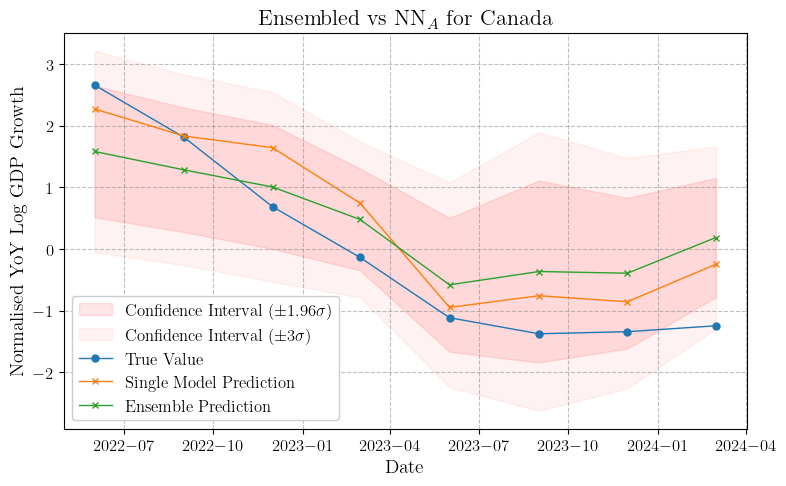

In [24]:
SELECTED_COUNTRY = 'Canada'

plt.style.use('ieee.mplstyle')
filtered_data = y_pred_country_ensemble[y_pred_country_ensemble["country"] == SELECTED_COUNTRY]

plt.figure(figsize=(8, 5))

multiplier1 = 1.96  # ~95% confidence
multiplier2 = 3  # ~99.7% confidence
        
# First confidence interval (e.g., ±3σ)
plt.fill_between(
    filtered_data["date"],
    filtered_data["Ensemble Prediction"] - multiplier1 * filtered_data['Std'],
    filtered_data["Ensemble Prediction"] + multiplier1 * filtered_data['Std'],
    color='red',
    alpha=0.1,
    label=f'Confidence Interval ($\pm {multiplier1}\sigma$)'
)

# Second confidence interval (e.g., ±1.96σ for ~95% confidence)
plt.fill_between(
    filtered_data["date"],
    filtered_data["Ensemble Prediction"] - multiplier2 * filtered_data['Std'],
    filtered_data["Ensemble Prediction"] + multiplier2 * filtered_data['Std'],
    color='red',
    alpha=0.05,
    label=f'Confidence Interval ($\pm {multiplier2}\sigma$)'
)

plt.plot(filtered_data["date"], filtered_data["True value"], label="True Value", marker='o')
plt.plot(filtered_data["date"], filtered_data["Single Model Prediction"], label="Single Model Prediction", marker='x')
plt.plot(filtered_data["date"], filtered_data["Ensemble Prediction"], label="Ensemble Prediction", marker='x') 

plt.title("Ensembled vs $\\text{NN}_A$ for " + SELECTED_COUNTRY)
plt.xlabel("Date")
plt.ylabel("Normalised YoY Log GDP Growth")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot
plt.savefig(results.OUTPUT_DATA_PATH + f"{SELECTED_COUNTRY}_low_frequency_predictions.pdf")
plt.show()

plt.rcdefaults()

In [25]:
import utils.results as results

plt.rcdefaults()

# Put together the train and the validation set
predictions = pd.concat([y_pred_train_country, y_pred_country])

# Melting the dataframe for better plotting
predictions_melted = predictions.melt(
    id_vars=["date", "country", "Set"],
    value_vars=["Single Model Prediction", "True value"], 
    var_name="Type", value_name="Value"
)

# Function to plot data for the selected country
def plot_by_country(selected_country):
    filtered_data = predictions_melted[predictions_melted["country"] == selected_country]
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=filtered_data,
        x="date", y="Value", hue="Type", errorbar = None, style="Set", markers=True
    )
    plt.title(f"Low frequency predictions vs true values for {selected_country}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.legend(ncol=2)
    plt.grid(True)
    plt.tight_layout()

    plt.show()


# Create a dropdown widget for selecting the country
countries = predictions["country"].unique()
dropdown = widgets.Dropdown(
    options=countries,
    value=countries[0],
    description='Country:'
)

# Use the interact function to link the dropdown with the plot function
interact(plot_by_country, selected_country=dropdown)

plt.show()

interactive(children=(Dropdown(description='Country:', options=('Canada', 'Germany', 'Korea', 'Switzerland', '…

### Paper plot

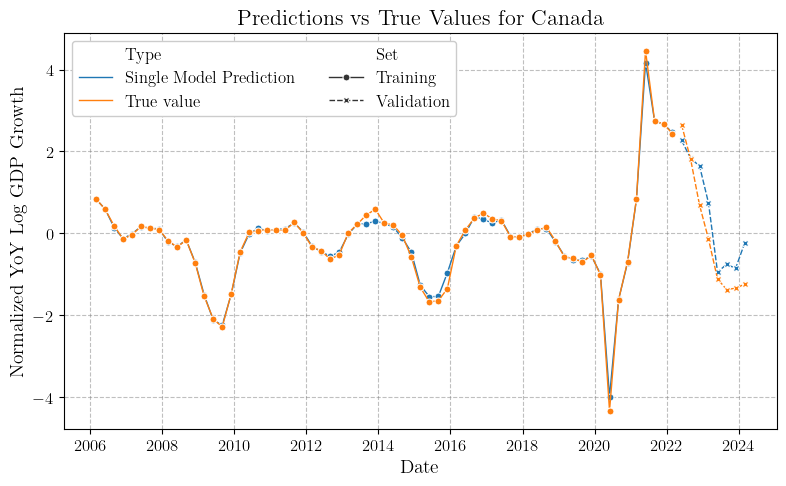

In [26]:
plt.style.use('ieee.mplstyle')

SELECTED_COUNTRY = 'Canada'

filtered_data = predictions_melted[predictions_melted["country"] == SELECTED_COUNTRY]
plt.figure(figsize=(8, 5))
sns.lineplot(
    data=filtered_data,
    x="date", y="Value", hue="Type", errorbar = None, style="Set", markers=True
)
plt.title(f"Predictions vs True Values for {SELECTED_COUNTRY}")
plt.xlabel("Date")
plt.ylabel("Normalized YoY Log GDP Growth")
plt.legend(loc='upper left', ncol=2)
plt.grid(True)
plt.tight_layout()

# Save the plot
plt.savefig(results.OUTPUT_DATA_PATH + f"{SELECTED_COUNTRY}_simple_predictions.pdf")
plt.show()

plt.rcdefaults()

## High frequency predictions

In [27]:
# Predict for the high frequency data
y_pred_high_freq = model(torch.tensor(x_high_freq, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
y_pred_high_freq_country = pd.DataFrame({'date': preprocessor.dates_high_freq, 'country': preprocessor.country_high_freq, 'y_pred': y_pred_high_freq})

In [28]:
# Get the true GDPs
country_train = preprocessor.country_train
country_valid = preprocessor.country_valid
all_true_gdps_country = np.concatenate([y_train, y_valid], axis=0)
all_dates = pd.concat([preprocessor.dates_train, preprocessor.dates_valid], axis=0)
all_true_gdps_country = pd.DataFrame({'date': all_dates, 'country': np.concatenate([country_train, country_valid], axis=0), 'y_true': np.concatenate([y_train, y_valid], axis=0)})

In [ ]:
# Set the predicions to be plotted
predictions = y_pred_high_freq_country

# Add the true gdp for the points that we have
predictions = predictions.merge(all_true_gdps_country, on=["date", "country"], how="left")

# Remove duplicates
predictions = predictions.drop_duplicates(subset=["date", "country"])

# Rename y_pred to y_pred_high_freq
predictions = predictions.rename(columns={"y_pred": "High Frequency Prediction", "y_true": "True Value"})

In [30]:
# Function to plot data for the selected country
def plot_by_country(selected_country):
    filtered_data = predictions[predictions["country"] == selected_country]
    cutoff_date = predictions['date'].quantile(TRAIN_PROPORTION)
    non_nans = filtered_data["True Value"].notna()
    y_trues = filtered_data["True Value"][non_nans]
    plt.figure(figsize=(15, 5))
    plt.plot(filtered_data["date"], filtered_data["High Frequency Prediction"], label="Predicted")
    plt.plot(filtered_data["date"][non_nans], y_trues, label="True")
    plt.title(f"High frequency predictions vs True Values for {selected_country}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.axvline(x=cutoff_date, color='red', linestyle='--', label=f'Validation Start ({TRAIN_PROPORTION}%)')
    plt.legend(title="Legend")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Create a dropdown widget for selecting the country
countries = predictions["country"].unique()
countries.sort()
dropdown = widgets.Dropdown(
    options=countries,
    value=countries[0],
    description='Country:'
)

# Use the interact function to link the dropdown with the plot function
interact(plot_by_country, selected_country=dropdown)

plt.show()

interactive(children=(Dropdown(description='Country:', options=('Canada', 'Germany', 'Japan', 'Korea', 'Switze…

### Paper plot

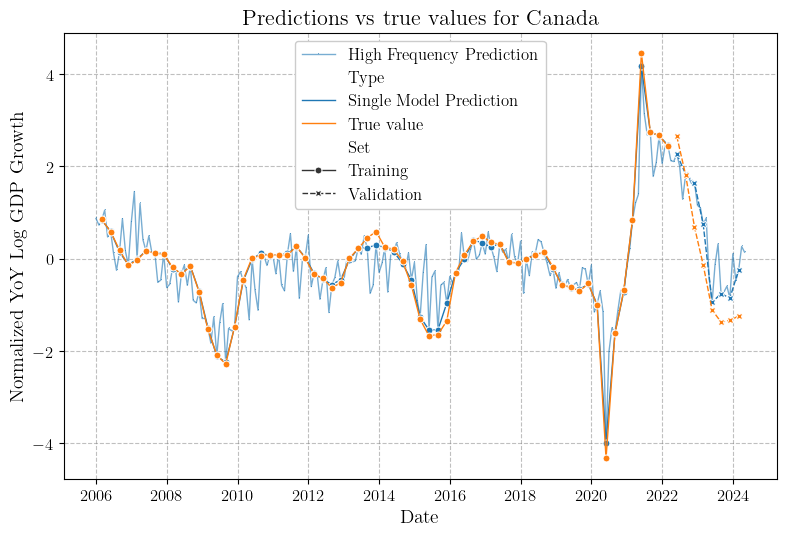

In [31]:
plt.style.use('ieee.mplstyle')
SELECTED_COUNTRY = 'Canada'

filtered_data = predictions_melted[predictions_melted["country"] == SELECTED_COUNTRY]
filtered_hf_data = predictions[predictions["country"] == SELECTED_COUNTRY]

plt.figure(figsize=(8, 5.5))

plt.plot(filtered_hf_data["date"], 
         filtered_hf_data["High Frequency Prediction"], 
         label="High Frequency Prediction", 
         color="#1F77B4",
         linewidth=1,
         marker=',', 
         alpha=0.6)

sns.lineplot(
    data=filtered_data,
    x="date", y="Value", hue="Type", errorbar = None, style="Set", markers=True
)

plt.title(f"Predictions vs true values for {SELECTED_COUNTRY}")
plt.xlabel("Date")
plt.ylabel("Normalized YoY Log GDP Growth")
plt.legend(ncol=1)
plt.grid(True)
plt.tight_layout()

# Save the plot
plt.savefig(results.OUTPUT_DATA_PATH + f"{SELECTED_COUNTRY}_hf_simple_predictions.pdf")
plt.show()